In [4]:
# case specification
dafiCase = '../case-1/'
sampleId = 50
timeDir = 100

In [5]:
#############################################################################
# load data
#############################################################################
# plot flow field
import os
import numpy as np
import fluidfoam as ff

##############################################################################
foamCase = os.path.join(dafiCase, 'results_ensemble', f'sample_{sampleId}')
U = ff.readvector(foamCase, f'{timeDir:g}', 'U')
theta1 = ff.readscalar(foamCase, f'{timeDir:g}', 'theta1')
theta2 = ff.readscalar(foamCase, f'{timeDir:g}', 'theta2')
theta3 = ff.readscalar(foamCase, f'{timeDir:g}', 'theta3')
theta4 = ff.readscalar(foamCase, f'{timeDir:g}', 'theta4')
theta5 = ff.readscalar(foamCase, f'{timeDir:g}', 'theta5')
theta6 = ff.readscalar(foamCase, f'{timeDir:g}', 'theta6')
g1 = ff.readscalar(foamCase, f'{timeDir:g}', 'g1')
g2 = ff.readscalar(foamCase, f'{timeDir:g}', 'g2')
g3 = ff.readscalar(foamCase, f'{timeDir:g}', 'g3')
g4 = ff.readscalar(foamCase, f'{timeDir:g}', 'g4')
print('Ux, min, max', U[0, :].min(), U[0, :].max())
print('Uy, min, max', U[1, :].min(), U[1, :].max())
print('Uz, min, max', U[2, :].min(), U[2, :].max())
print('theta1, min, max', theta1.min(), theta1.max())
print('theta2, min, max', theta2.min(), theta2.max())
print('theta3, min, max', theta3.min(), theta3.max())
print('theta4, min, max', theta4.min(), theta4.max())
print('theta5, min, max', theta5.min(), theta5.max())
print('theta6, min, max', theta6.min(), theta6.max())
x, y, z = ff.readmesh(foamCase)

theta = np.concatenate(
    (theta1.reshape(-1, 1), theta2.reshape(-1, 1), theta3.reshape(-1, 1),
     theta4.reshape(-1, 1), theta5.reshape(-1, 1), theta6.reshape(-1, 1)),
    axis=1)

g = np.concatenate(
    (g1.reshape(-1, 1), g2.reshape(-1, 1), g3.reshape(-1, 1), g4.reshape(
        -1, 1)),
    axis=1)

np.savetxt(
    f'theta-range-{sampleId}.csv',
    np.concatenate(
        (theta.min(axis=0).reshape(-1, 1), theta.max(axis=0).reshape(-1, 1)),
        axis=1),
    delimiter=',')

print(theta)

Reading file ../case-1/results_ensemble/sample_50/100/U
Reading file ../case-1/results_ensemble/sample_50/100/theta1
Reading file ../case-1/results_ensemble/sample_50/100/theta2
Reading file ../case-1/results_ensemble/sample_50/100/theta3
Reading file ../case-1/results_ensemble/sample_50/100/theta4
Reading file ../case-1/results_ensemble/sample_50/100/theta5
Reading file ../case-1/results_ensemble/sample_50/100/theta6
Reading file ../case-1/results_ensemble/sample_50/100/g1
Reading file ../case-1/results_ensemble/sample_50/100/g2
Reading file ../case-1/results_ensemble/sample_50/100/g3
Reading file ../case-1/results_ensemble/sample_50/100/g4
Ux, min, max 0.000940639 1.32315
Uy, min, max -0.00129902 0.00181287
Uz, min, max -0.00129902 0.00181287
theta1, min, max 0.00334674 7.52324
theta2, min, max -7.52324 -0.00334674
theta3, min, max -0.20568 0.203749
theta4, min, max -0.0679166 0.0685601
theta5, min, max -28.2996 -5.60033e-06
theta6, min, max -1.4e-14 0.0127022
Reading file ../case-1/

In [6]:
################################################################
# load neural network
import time
import tensorflow as tf
import numpy as np
import os

# set threads of tf = 1
os.environ["TF_NUM_INTEROP_THREADS"] = "1"  #
os.environ["TF_NUM_INTRAOP_THREADS"] = "1"  #
# set threads of openmp = 1
os.environ["OMP_NUM_THREADS"] = "1"  #

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

f = open('python_module.log', 'w+')
print('_________________________________________________________________',
      file=f)
print('Computing function of scalar invariants from Python module', file=f)
print('Tensorflow version', tf.__version__, file=f)
print('_________________________________________________________________',
      file=f)

# tf.keras.backend.clear_session()
# tf.config.threading.set_intra_op_parallelism_threads(2)
# load model

model_path = '../NN-pre-train/nn_model_235.h5'
model = tf.keras.models.load_model(model_path)
# model.summary()

# load weights
# get weights flatten
weights_flatten = np.loadtxt(
    os.path.join(dafiCase, 'results_ensemble', f'sample_{sampleId}',
                 'nn_weights_flatten.dat'))
# weights_flatten = np.loadtxt('/home/wuct/dafi/pehills-NN-closure/inputs/w.0')

# get model shape
shapes = []
for iw in model.trainable_variables:
    shapes.append(iw.shape)

# shapes to sizes
sizes = []
for shape in shapes:
    isize = 1
    for ishape in shape:
        isize *= ishape
    sizes.append(isize)

# reshape weights
w_reshaped = []
i = 0
for shape, size in zip(shapes, sizes):
    w_reshaped.append(weights_flatten[i:i + size].reshape(shape))
    i += size
    # print(w_reshaped)
model.set_weights(w_reshaped)

print(model.get_weights(), file=f)
print('Neural-network weights loaded successfully', file=f)


def ml_func(array):
    # print(np.shape(array))
    array_scaled = np.zeros_like(array)
    t12 = np.loadtxt(f'theta-range-{sampleId}.csv', delimiter=',')

    array_scaled[:, 0] = (array[:, 0] - t12[0, 0]) / (t12[0, 1] - t12[0, 0])
    array_scaled[:, 1] = (array[:, 1] - t12[1, 0]) / (t12[1, 1] - t12[1, 0])
    array_scaled[:, 2] = (array[:, 2] - t12[1, 0]) / (t12[1, 1] - t12[1, 0])
    array_scaled[:, 3] = (array[:, 3] - t12[1, 0]) / (t12[1, 1] - t12[1, 0])
    array_scaled[:, 4] = (array[:, 4] - t12[1, 0]) / (t12[1, 1] - t12[1, 0])
    array_scaled[:, 5] = (array[:, 5] - t12[1, 0]) / (t12[1, 1] - t12[1, 0])

    g_ = model(array_scaled, training=False)

    g = np.array(g_).reshape(-1, 5).astype('double')
    # print(g)
    scale = [1.e-1, 1.e-3, 1.e-3, 1.e-3, 0]  # [0.1,0.001,0.001,0.001]
    init = [-0.09, 0, 0, 0, 0]  # [-0.09,1e-4,1e-4,1e-4]
    for i in range(g.shape[1]):
        # scale[i]*g[:, i] + (1.0 - scale[i])*init[i]
        g[:, i] = scale[i] * g[:, i] + init[i]

    # print(g)

    for i in range(g.shape[0]):
        for j in range(g.shape[1]):
            if j == 0 and g[i, j] > -0.0:
                g[i, j] = -0.0
            # if j == 1 and g[i, j] > 0.01: g[i, j] = 0.01
            # if j == 2 and g[i, j] < -0.01: g[i, j] = -0.01
            # if j == 3 and g[i, j] < -0.01: g[i, j] = -0.01
    # print('using tensorflow time', time.time() - t1)

    return g


def g1_nn(theta_):
    g_ = ml_func(theta_)
    # perturbed_data = g_[:, 0] + np.random.normal(0, 1e-8, np.shape(g_[:, 0]))
    return g_[:, 0]  #+ perturbed_data


def g1_SHIH(theta_):
    if (theta_[:, 0] < 0).any():
        print('x1 need be larger than zero')
        return
    if (theta_[:, 1] > 0).any():
        print('x2 need be less than zero')
        return
    return -(2.0 / 3.0) / (1.25 + np.sqrt(2 * theta_[:, 0]) +
                           0.9 * np.sqrt(-2 * theta_[:, 1]))


def g1_SR(theta_):
    if (theta_[:, 0] < 0).any():
        print('x1 need be larger than zero')
        return
    if (theta_[:, 1] > 0).any():
        print('x2 need be less than zero')
        return
    if (theta_[:, 2] > 0).any():
        print('x2 need be less than zero')
        return
    return -0.049231511193 * np.exp(
        np.cos(theta_[:, 0] / (np.pi + theta_[:, 2] / theta_[:, 1])))


def g1_Shih(x1, x2):
    if (x1 < 0).any():
        print('x1 need be larger than zero')
        return
    if (x2 > 0).any():
        print('x2 need be less than zero')
        return
    return -(2.0 / 3.0) / (1.25 + np.sqrt(2 * x1) + 0.9 * np.sqrt(-2 * x2))


def g2_Shih(x1):
    if (x1 < 0).any():
        print('x1 need be larger than zero')
        return
    return 7.5 / (1000 + np.power(2 * x1, 1.5))


def g3_Shih(x1):
    if (x1 < 0).any():
        print('x1 need be larger than zero')
        return
    return 1.5 / (1000 + np.power(2 * x1, 1.5))


def g4_Shih(x1):
    if (x1 < 0).any():
        print('x1 need be larger than zero')
        return
    return -9.5 / (1000 + np.power(2 * x1, 1.5))


def g1_f1(x):
    return -0.811975 + np.sin(np.exp(-1 + np.cos(np.cos(x / (1 + x)))))


def g1_f2(x):
    return -2.049392324734 + np.sqrt(3 + x / (1 + x))


def g1_f3(x):
    return -0.048698673009 * np.exp((2 + np.pi) / (x + np.pi))


def g1_f4(x):
    return 0.087809426432 - np.log(np.log(np.pi + 1 / (1 + x)))


def g1_f5(x):
    return -0.04868680962 * (2 * np.pi + x) / (1 + x)


def g1_f6(x):
    return -0.178159448988 / np.log(2 + x)

def g1_f7(x):
    return -0.078977071873*np.pi/(np.sqrt(x)+1.0-np.sin(1.0/np.sqrt(np.pi)))


def g1_f1_shih(x):
    return -0.248114589469 / (1 - np.sin(1 / np.sqrt(np.pi)) + np.sqrt(x))


In [7]:
###########################################################################################
# plot

import matplotlib.pyplot as plt

plt.rcParams.update({
    # "text.usetex": True,
    # "font.family": "Helvetica"
    'figure.dpi': 1000,
    'axes.labelsize': 6,
    'xtick.direction': 'in',
    'xtick.labelsize': 6,
    'xtick.top': True,
    'xtick.major.width': 0.5,
    'ytick.direction': 'in',
    'ytick.labelsize': 6,
    'ytick.right': True,
    'ytick.major.width': 0.5,
    'legend.fontsize': 6,
    'axes.linewidth': 0.5,
    'axes.titlesize': 6,
    'grid.linewidth': 0.5
})

vars = [
    r'$\theta_1$', r'$\theta_2$', r'$\theta_3$', r'$\theta_4$', r'$\theta_5$',
    r'$\theta_6$'
]

###################################################################
# plot predictions
plotStyleNN = {
    'linestyle': 'none',
    'marker': '.',
    'color': 'gray',
    'markersize': 5,
    'markeredgewidth': 0.5,
    'markerfacecolor': 'none',
    'alpha': 0.3
}

plotStyleReduced = {
    'linestyle': 'none',
    'marker': '.',
    'color': 'dodgerblue',
    'markersize': 2,
    'markeredgewidth': 0.5,
    'alpha': 0.5
}
plotStyleSHIH = {
    'linestyle': 'none',
    'marker': '.',
    'color': 'gray',
    'markersize': 2,
    'markeredgecolor': 'none',
    # 'markerfacecolor': 'none',
    'alpha': 0.5
}
plotStyleShih = {'linestyle': '-', 'color': 'brown', 'linewidth': 0.75}
plotStyleSR = {'linestyle': '-', 'color': 'dodgerblue', 'linewidth': 0.75}


<>:27: DeprecationWarning: invalid escape sequence \|
<>:27: DeprecationWarning: invalid escape sequence \|
/tmp/ipykernel_562/4071944500.py:27: DeprecationWarning: invalid escape sequence \|
  label='$\|Shih-SR\|$')


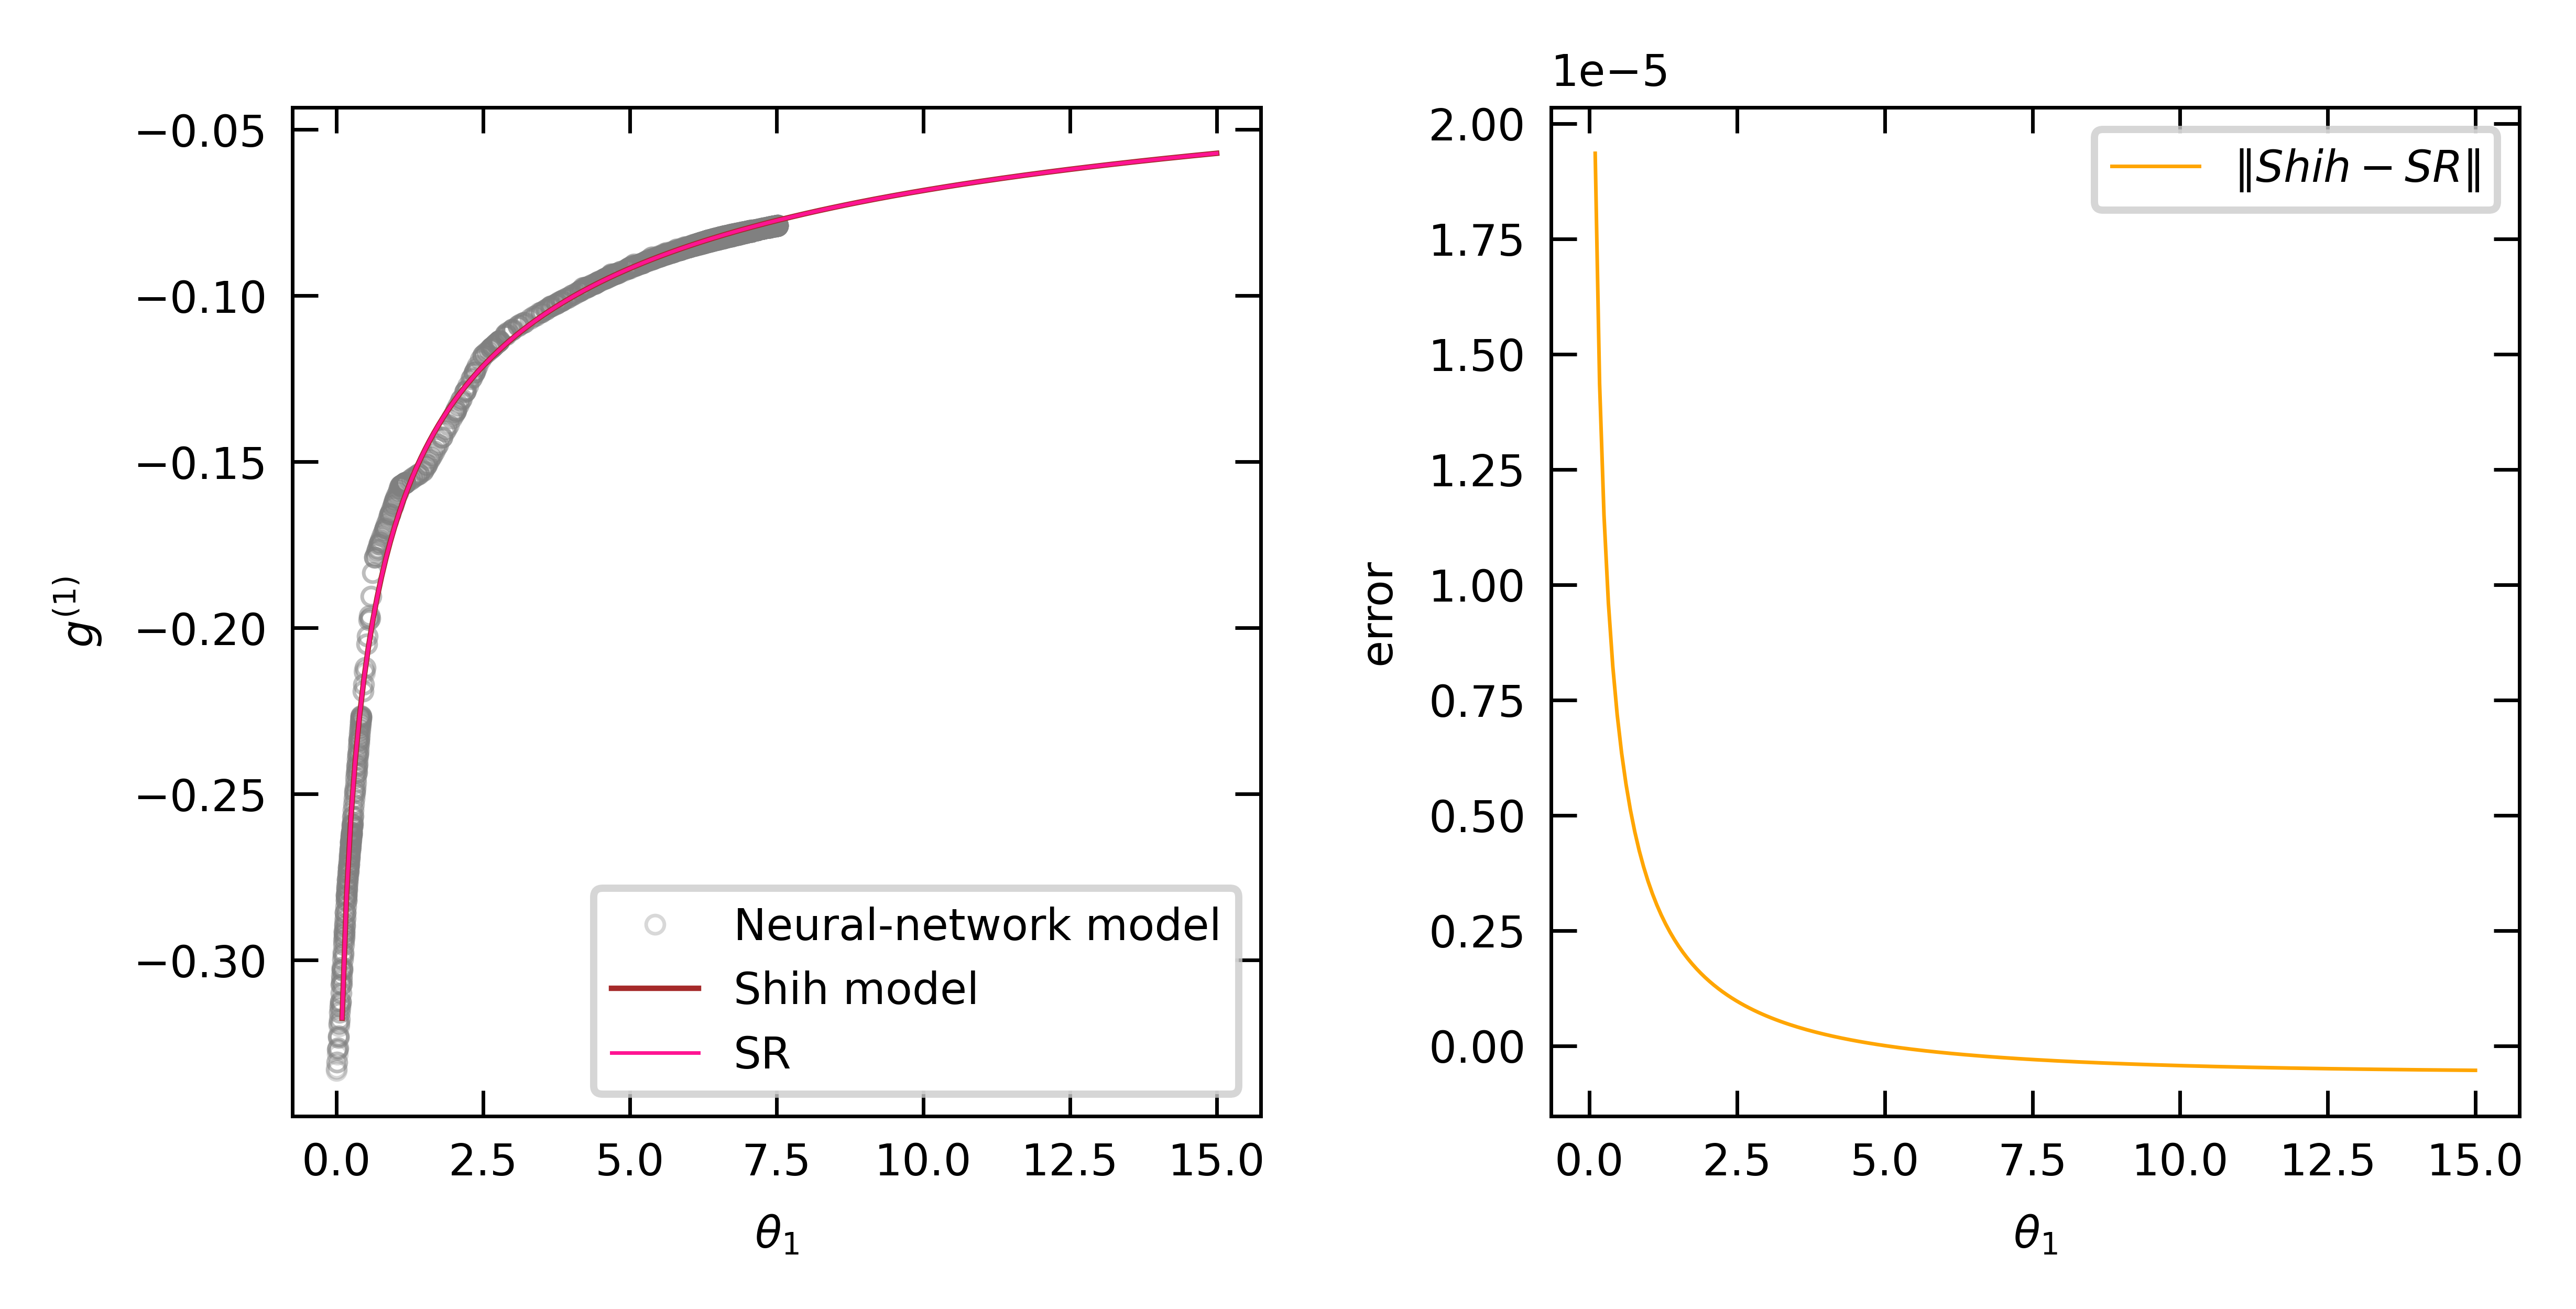

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(5, 2.5))
for i in range(2):
    pass
    # ax[i].ticklabel_format(style='sci', scilimits=(-1, 1))
ax[0].plot(theta[:, 0],
           g1_nn(theta),
           **plotStyleNN,
           label='Neural-network model')

t1 = np.linspace(0.1, 15, 201)
ax[0].plot(t1, g1_Shih(t1, -t1), **plotStyleShih, label='Shih model')
# ax[0].plot(t1, g1_f1(t1), color='orange', linewidth=0.5, label='f1')
# ax[0].plot(t1, g1_f2(t1), color='limegreen', linewidth=0.5, label='f2')
# ax[0].plot(t1, g1_f3(t1), color='dodgerblue', linewidth=0.5, label='f3')
# ax[0].plot(t1, g1_f4(t1), color='slateblue', linewidth=0.5, label='f4')
# ax[0].plot(t1, g1_f5(t1), color='purple', linewidth=0.5, label='f5')
ax[0].plot(t1, g1_f7(t1), color='deeppink', linewidth=0.5, label='SR')
# ax[0].plot(t1, g1_f1_shih(t1), color='red', linewidth=0.5, label='f1 Shih')
# ax.plot(t1, g1_SR(t_table), **plotStyleSR, label='Symbolic Regression')

ax[1].plot(t1,
           g1_f7(t1) - g1_Shih(t1, -t1),
           color='orange',
           linewidth=0.5,
           label='$\|Shih-SR\|$')
# ax[1].plot(t1,
#            g1_f2(t1) - g1_Shih(t1, -t1),
#            color='limegreen',
#            linewidth=0.5,
#            label='f2')
# ax[1].plot(t1,
#            g1_f3(t1) - g1_Shih(t1, -t1),
#            color='dodgerblue',
#            linewidth=0.5,
#            label='f3')
# ax[1].plot(t1,
#            g1_f4(t1) - g1_Shih(t1, -t1),
#            color='slateblue',
#            linewidth=0.5,
#            label='f4')
# ax[1].plot(t1,
#            g1_f5(t1) - g1_Shih(t1, -t1),
#            color='purple',
#            linewidth=0.5,
#            label='f5')
# ax[1].plot(t1,
#            g1_f6(t1) - g1_Shih(t1, -t1),
#            color='deeppink',
#            linewidth=0.5,
#            label='f6')
# ax[1].plot(t1,
#            g1_f1_shih(t1) - g1_Shih(t1, -t1),
#            color='red',
#            linewidth=0.5,
#            label='f1 Shih')
ax[0].set(xlabel=r'$\theta_1$', ylabel=r'$g^{(1)}$')
ax[1].set(xlabel=r'$\theta_1$', ylabel=r'error')
ax[0].legend()
ax[1].legend()
plt.subplots_adjust(left=0.1, right=0.95,wspace=0.3)
plt.savefig('check-SR.png')